In [19]:
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_addons as tfa
from matplotlib import pyplot as plt
import numpy as np

In [21]:
tf.__version__

'2.9.1'

In [7]:
(train_ds, valid_ds, test_ds), info = tfds.load(
    name="fashion_mnist",
    as_supervised=True,
    with_info=True,
    split=["train[:80%]", "train[80%:]", "test"]
)

2022-07-09 09:36:24.923276: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-09 09:36:24.923349: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-09 09:36:24.923401: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (calcifer-Inspiron-7370): /proc/driver/nvidia/version does not exist
2022-07-09 09:36:24.924162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
num_classes = info.features['label'].num_classes
input_shape = info.features['image'].shape

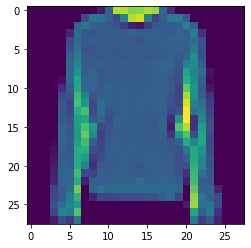

In [9]:
it = train_ds.as_numpy_iterator()
(image, label) = it.next()

plt.imshow(image)

2022-07-09 09:36:26.504276: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


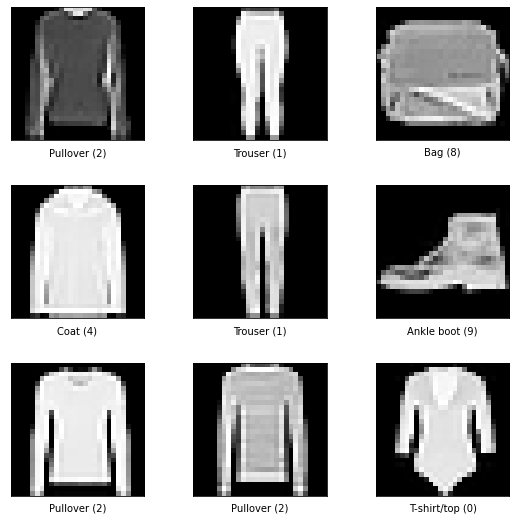

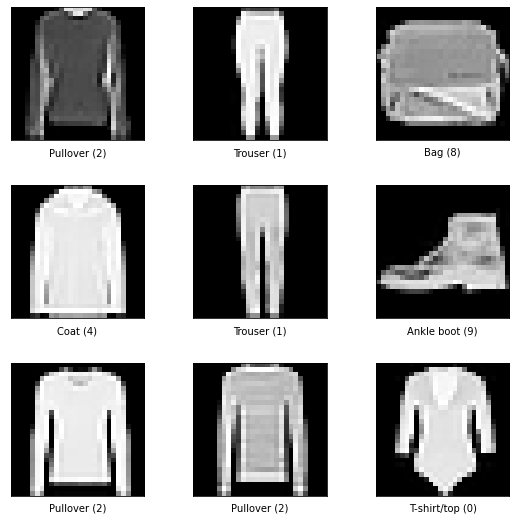

In [10]:
tfds.visualization.show_examples(train_ds, info)

## Basic ConvNet

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, ReLU, Add, Conv2D, Dense, Flatten, Rescaling, MaxPool2D, Dropout
from tensorflow_addons.layers import GroupNormalization

In [118]:
tf.keras.backend.clear_session()
np.random.seed(0)

model = Sequential([
    Input(shape=input_shape, batch_size=BATCH_SIZE),
    Rescaling(scale=1./127.5, offset=-1),
    Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'),
    Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
    Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'),
    Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(num_classes, activation="softmax"),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (64, 28, 28, 1)           0         
                                                                 
 conv2d (Conv2D)             (64, 26, 26, 64)          640       
                                                                 
 conv2d_1 (Conv2D)           (64, 24, 24, 64)          36928     
                                                                 
 max_pooling2d (MaxPooling2D  (64, 23, 23, 64)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (64, 21, 21, 32)          18464     
                                                                 
 conv2d_3 (Conv2D)           (64, 19, 19, 32)          9248      
                                                        

In [119]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics="accuracy",
)

In [120]:
BATCH_SIZE = 64

In [121]:
train_ds_batched = train_ds.batch(BATCH_SIZE).cache().prefetch(1)
valid_ds_batched = valid_ds.batch(BATCH_SIZE).cache().prefetch(1)

In [122]:
callbacks = tf.keras.callbacks.TensorBoard(log_dir="logs/", histogram_freq=1)

model.fit(
    train_ds_batched,
    validation_data=valid_ds_batched,
    batch_size=BATCH_SIZE,
    epochs=5,
    callbacks=callbacks,
    use_multiprocessing=True,
    workers=8,
)

Epoch 1/5
750/750 [==============================] - 112s 149ms/step - loss: 0.5108 - accuracy: 0.8161 - val_loss: 0.2933 - val_accuracy: 0.8883
Epoch 2/5
750/750 [==============================] - 115s 154ms/step - loss: 0.3201 - accuracy: 0.8855 - val_loss: 0.2593 - val_accuracy: 0.8996
Epoch 3/5
750/750 [==============================] - 115s 153ms/step - loss: 0.2695 - accuracy: 0.9018 - val_loss: 0.2629 - val_accuracy: 0.9052
Epoch 4/5
750/750 [==============================] - 117s 156ms/step - loss: 0.2355 - accuracy: 0.9135 - val_loss: 0.2417 - val_accuracy: 0.9107
Epoch 5/5
750/750 [==============================] - 114s 152ms/step - loss: 0.2124 - accuracy: 0.9241 - val_loss: 0.2690 - val_accuracy: 0.9067


## ResNet

In [230]:
from tensorflow import Tensor

In [231]:
def res_block(
    x: Tensor, 
    filters: int = 64, 
    kernel_size: int = 3, 
    groups=8, 
    downsample: bool = False
) -> Tensor:
    strides_ = 2 if downsample else 1
    y = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides_, padding="same")(x)
    y = GroupNormalization(groups=groups)(y)
    y = ReLU()(y)
    z = Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding="same")(y)
    j = Add()([y, z])
    j = GroupNormalization(groups=groups)(j)
    j = ReLU()(j)
    return j

In [235]:
from tensorflow.keras.models import Model


tf.keras.backend.clear_session()
np.random.seed(0)

inputs = Input(shape=input_shape)
x = Rescaling(scale=1./127.5, offset=-1)(inputs)
x = res_block(x, filters=32)
x = res_block(x, filters=64, downsample=False)
x = res_block(x, filters=128, downsample=True)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)                                         
x = Dense(10, activation="softmax")(x)

model = Model(inputs, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 28, 28, 1)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['rescaling[0][0]']              
                                                                                                  
 group_normalization (GroupNorm  (None, 28, 28, 32)  64          ['conv2d[0][0]']                 
 alization)                                                                                   

In [236]:
model.compile(
    optimizer=Adam(),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [238]:
history = model.fit(
    train_ds_batched.take(BATCH_SIZE*10),
    epochs=5,
    batch_size=BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir="./logs-resnet"),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss'),
    ],
    validation_data=valid_ds_batched,
    use_multiprocessing=True,
    workers=8,
)

Epoch 1/5
 15/640 [..............................] - ETA: 3:43 - loss: 3.7478 - accuracy: 0.1250

KeyboardInterrupt: 

In [216]:
model.save_weights("./models/resnet")

In [220]:
loss, accuracy = model.evaluate(test_ds.batch(64).cache().prefetch(1))

157/157 [==============================] - 16s 100ms/step - loss: 0.2948 - accuracy: 0.9064


In [229]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

NameError: name 'history' is not defined